## **Introduction**
This notebook presents a comprehensive approach to classifying brain images into two categories: Normal and Tumor, using a deep learning model based on the ResNet50 architecture. It begins with preparing and preprocessing the dataset, including splitting it into training and validation sets, and applying necessary transformations to the images. The notebook then proceeds to define and train the ResNet50 model, adjusting the final layer to suit our binary classification task. Throughout the training process, we monitor performance metrics such as loss and accuracy, both on the training and validation datasets, to evaluate the model's performance and ensure it learns effectively. Additionally, we implement functionality to save the best-performing model based on validation accuracy. Finally, the notebook demonstrates how to use the trained model to make predictions on new brain images, providing a practical tool for aiding in the diagnosis of brain tumors. This end-to-end workflow not only showcases the application of transfer learning in medical imaging but also serves as a template for similar classification tasks within the field of healthcare.

## **Importing Necessary Libraries**

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchinfo import summary
import torch.optim as optim
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Config**

In [2]:
# Define the path to the folders containing the normal and tumor images in the dataset.
normal_folder_path = "/kaggle/input/brain-tumors-dataset/Data/Normal"
tumor_folder_path = "/kaggle/input/brain-tumors-dataset/Data/Tumor"

# Set the training data size percentage, batch size for the DataLoader, number of epochs for training,
# and learning rate for the optimizer.
train_size = 0.80  # 80% of data will be used for training, 20% for validation
batch_size = 32  # Number of samples per gradient update
num_epochs = 10  # Number of complete passes through the dataset
learning_rate = 0.001  # Step size at each iteration while moving toward a minimum of a loss function

# Choose the device to run the model on - use CUDA if available, else fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a series of transformations to apply to the images. This standardizes the size of images,
# converts them to tensor format, and normalizes their pixel values.
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize pixel values
])

## **Processing File Paths of our Dataset**

In [3]:
# Initialize empty lists to store file paths and labels for the images.
file_paths = []
labels = []

# Walk through the tumor folder directory to find all files.
for subdir, dirs, files in os.walk(tumor_folder_path):
    for file in files:
        # Check if the file is an image (jpg, jpeg, png).
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # If so, append the file path to the file_paths list and add a corresponding label to the labels list.
            file_paths.append(os.path.join(subdir, file))  # Full path to the file
            labels.append('Tumor')  # Label for the file

# Create a dataframe from the lists, with columns for file paths and labels.
df_tumors = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Display the shape of the dataframe to check the number of entries and columns.
df_tumors.shape

(18606, 2)

In [4]:
# Display the first 5 rows of the DataFrame to preview the data
df_tumors.head(5)

,file_path,label
0,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
1,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
2,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
3,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
4,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor


In [5]:
# Initialize empty lists to hold file paths and labels for the normal images.
normal_file_paths = []
normal_labels = []

# Loop through all files in the directory specified by 'normal_folder_path'.
for file in os.listdir(normal_folder_path):
    # Check if the file is an image based on its extension (jpg, jpeg, png).
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        # If so, append the full file path to the 'normal_file_paths' list.
        normal_file_paths.append(os.path.join(normal_folder_path, file))
        # Append the label 'Normal' to the 'normal_labels' list.
        normal_labels.append('Normal')

# Create a DataFrame from the lists, with columns for file paths and labels.
df_normal = pd.DataFrame({
    'file_path': normal_file_paths,
    'label': normal_labels
})

# Display the shape of the DataFrame to see how many entries it contains.
df_normal.shape

(3066, 2)

In [6]:
# Merging the two DataFrames: df_tumors and df_normal. The resulting DataFrame, df_merged,
# will contain all entries from both DataFrames. The ignore_index=True parameter ensures
# that the DataFrame is reindexed from 0 to the total number of rows minus one.
df_merged = pd.concat([df_tumors, df_normal], ignore_index=True)

# Display the shape of the merged DataFrame to see the total number of rows (images)
# and columns (file path and label). This gives an idea of the total dataset size after merging.
df_merged.shape

(21672, 2)

In [7]:
df_merged.tail(5)
df_merged.head(5)

,file_path,label
0,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
1,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
2,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
3,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor
4,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,Tumor


## **Custom DataLoader**

In [8]:
"""
The BrainTumorDataset class is a custom dataset loader extending the PyTorch Dataset class, designed 
for loading brain tumor images from a specified pandas DataFrame. This class facilitates the preprocessing 
and preparation of brain tumor images for model training or evaluation in a PyTorch-based machine learning 
workflow.

Attributes:
    dataframe (pd.DataFrame): A pandas DataFrame containing the file paths to the images in the first column 
        and their corresponding labels ('Normal' or 'Tumor') in the second column.
    transform (callable, optional): A function/transform that takes in an image and returns a transformed 
        version. Typical transforms include converting to tensor, resizing, normalization, etc.

Methods:
    __init__(self, dataframe, transform=None): Initializes the dataset object with the provided DataFrame 
        and an optional transform. If a transform is provided, it will be applied to each image during loading.
        
    __len__(self): Returns the total number of images in the dataset, facilitating iteration and sampling 
        over the dataset.
        
    __getitem__(self, idx): Retrieves an image by its index `idx` from the DataFrame, applies the optional 
        transform (if any), and returns the transformed image and its corresponding label as a tuple. The label 
        is also converted from a string ('Normal' or 'Tumor') to a binary numeric format (0 for 'Normal', 1 for 
        'Tumor') for compatibility with PyTorch loss functions that expect numerical labels.

Usage:
    This class is intended to be used with a PyTorch DataLoader, which allows for easy batching, 
    shuffling, and parallel loading using multiprocessing. To use this class, instantiate it with 
    a DataFrame containing your image paths and labels, and optionally, a transform. Then, pass the 
    instantiated object to a DataLoader to prepare your data for training or inference with a PyTorch model.
"""

class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        # Converting labels to'Normal' as 0 and 'Tumor' as 1
        label = torch.tensor(1 if label == 'Tumor' else 0, dtype=torch.long)
        
        return image, label

#### **Splitting Dataframe**

In [9]:
# Splitting the merged DataFrame into training and validation sets. The 'train_test_split' function from 
# sklearn.model_selection is used for this purpose. 'test_size' is determined by subtracting 'train_size' 
# from 1, ensuring the desired proportion of data is allocated to the training and validation sets. The 
# 'random_state' parameter ensures reproducibility of the split by providing a fixed seed to the random 
# number generator. 'Stratify' is set to the labels in 'df_merged', ensuring that both training and 
# validation sets have a similar proportion of 'Normal' and 'Tumor' labels as the original dataset.

train_df, val_df = train_test_split(df_merged, test_size=(1-train_size), random_state=42, stratify=df_merged['label'])

#### **Creating Train & Validation Dataloaders**

In [10]:
# Create instances of the BrainTumorDataset for both training and validation datasets.
# The 'dataframe' parameter is provided with the train_df and val_df DataFrames, respectively,
# which contain the file paths and labels for the images. The 'transform' parameter applies
# the specified transformations to the images (resizing, normalization, etc.) as defined previously.

train_dataset = BrainTumorDataset(dataframe=train_df, transform=transform)
val_dataset = BrainTumorDataset(dataframe=val_df, transform=transform)

# DataLoader is used to efficiently load the datasets for training and validation. The DataLoader
# for the training dataset is configured to shuffle the data (shuffle=True), which helps in reducing
# model overfitting by ensuring that each batch of data is different across epochs. For the validation
# DataLoader, shuffling is disabled (shuffle=False) as it is not necessary to shuffle data for validation
# or testing. The 'batch_size' parameter determines the number of samples per batch to load.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
num_train_images = len(train_loader.dataset)
num_val_images = len(val_loader.dataset)

print(f"Number of images in the training dataloader: {num_train_images}")
print(f"Number of images in the validation dataloader: {num_val_images}")

Number of images in the training dataloader: 17337
Number of images in the validation dataloader: 4335


## **Pre-trained Model**

In [12]:
def resNet50():
    # Load a pre-trained ResNet50 model with ImageNet weights.
    ResNet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Freeze all parameters to prevent updating during training.
    for param in ResNet50.parameters():
        param.requires_grad = False

    # Unfreeze the fully connected (fc) layer parameters for training.
    for param in ResNet50.fc.parameters():
        param.requires_grad = True

    # Replace the fc layer to match the number of classes (2: Normal, Tumor).
    in_features = ResNet50.fc.in_features  # Get input size of the original fc layer
    ResNet50.fc = nn.Linear(in_features, 2)  # Redefine fc layer for binary classification

    # Move the model to the specified device (GPU or CPU).
    return ResNet50.to(device)

In [13]:
# Instantiate the custom ResNet50 model for our task.
model = resNet50()

# Display a detailed summary of the model. The summary is customized to show specific columns:
# input size of each layer, output size of each layer, number of parameters in each layer,
# and whether the parameters are trainable. The input to the model is specified as a batch
# of 32 images, with 3 color channels, each 256x256 pixels. The 'col_width' and 'row_settings'
# options are set to enhance the readability of the summary output.
summary(model, input_size=(32, 3, 256, 256), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

## **Training Model**

In [14]:
# Define loss function and optimizer targeting the fully connected layer's parameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Initialize variables to track the best model and training/validation metrics.
best_accuracy = 0.0
best_model_path = "/kaggle/working/best_model.pth"
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):  # Loop over the dataset multiple times.
    model.train()  # Set model to training mode.
    total_loss, correct_train, total_train = 0, 0, 0
    for images, labels in train_loader:  # Iterate over the training dataset.
        images, labels = images.to(device), labels.to(device)  # Move data to the configured device.

        # Forward pass, calculate loss, perform backpropagation, and update weights.
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  # Clear gradients.
        loss.backward()  # Compute gradients.
        optimizer.step()  # Update parameters.

        # Calculate training loss and accuracy.
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Compute average loss and accuracy for the epoch.
    train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase: Evaluate the model on the validation dataset.
    model.eval()  # Set model to evaluation mode.
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():  # Disable gradient calculation.
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy, then update best model if improved.
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print training/validation statistics for the epoch.
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_accuracy:  # Save model if validation accuracy improves.
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved better model with accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.2037, Validation Loss: 0.1576, Train Accuracy: 91.91%, Validation Accuracy: 93.73%
Saved better model with accuracy: 93.73%
Epoch [2/10], Train Loss: 0.1562, Validation Loss: 0.1408, Train Accuracy: 93.93%, Validation Accuracy: 94.33%
Saved better model with accuracy: 94.33%
Epoch [3/10], Train Loss: 0.1341, Validation Loss: 0.1446, Train Accuracy: 94.72%, Validation Accuracy: 94.39%
Saved better model with accuracy: 94.39%
Epoch [4/10], Train Loss: 0.1285, Validation Loss: 0.1242, Train Accuracy: 95.15%, Validation Accuracy: 95.27%
Saved better model with accuracy: 95.27%
Epoch [5/10], Train Loss: 0.1240, Validation Loss: 0.1189, Train Accuracy: 95.01%, Validation Accuracy: 95.27%
Epoch [6/10], Train Loss: 0.1206, Validation Loss: 0.1163, Train Accuracy: 95.50%, Validation Accuracy: 95.73%
Saved better model with accuracy: 95.73%
Epoch [7/10], Train Loss: 0.1083, Validation Loss: 0.1088, Train Accuracy: 95.71%, Validation Accuracy: 95.73%
Epoch [8/10], Trai

## **Training & Validation Curves**

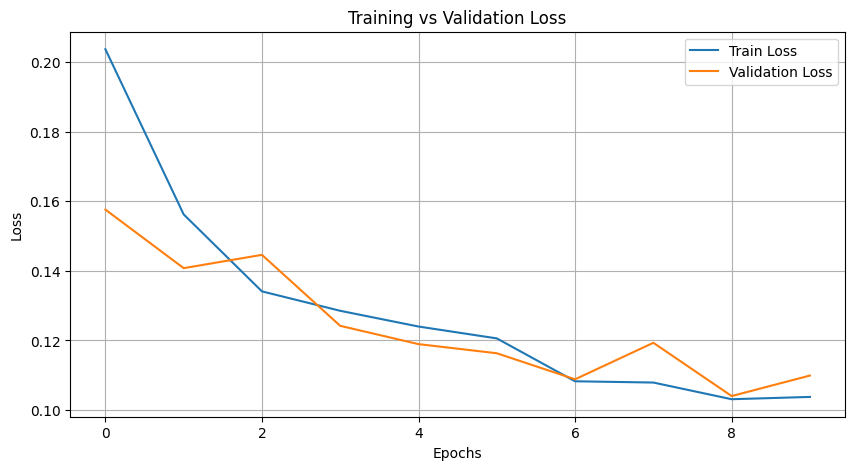

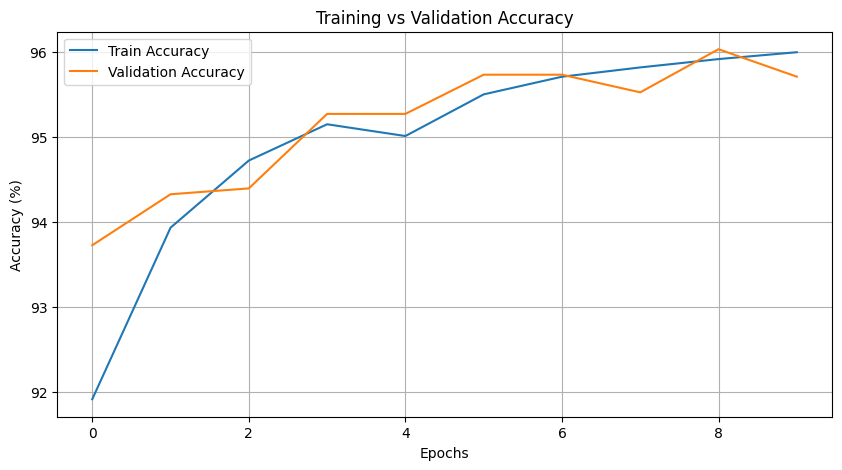

In [15]:
# Plot training and validation losses.
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')  # Plot training loss.
plt.plot(val_losses, label='Validation Loss')  # Plot validation loss.
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies.
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')  # Plot training accuracy.
plt.plot(val_accuracies, label='Validation Accuracy')  # Plot validation accuracy.
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## **Single Image Inference**

In [16]:
from PIL import Image
from torchvision import transforms
import torch

def predict_image(image_path, model_path):
    model = resNet50()  # Initialize the model structure.
    model.load_state_dict(torch.load(model_path))  # Load the trained model weights.
    model = model.to(device)  # Ensure the model runs on the configured device.
    model.eval()  # Set the model to evaluation mode.

    image = Image.open(image_path)  # Open the image file.
    image = transform(image).unsqueeze(0)  # Apply the transformations and add a batch dimension.
    image = image.to(device)  # Move the image tensor to the configured device.

    with torch.no_grad():  # Disable gradient computation for inference.
        outputs = model(image)  # Get the model's predictions.
        _, predicted = torch.max(outputs, 1)  # Determine the most likely class.
        
    classes = ['Normal', 'Tumor']  # Define the classes.
    result = classes[predicted[0]]  # Map the prediction to the corresponding class.
    print(f"The image is classified as: {result}")  # Print the classification result.

### Now input a random image from the dataset from Tumor class and let's see if our model can predict it correctly.

In [17]:
best_model_path = "/kaggle/working/best_model.pth"
image_path = "/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor/G_1.jpg" 

# Load the best model and predict the class of a specified brain image using our defined function.
predict_image(image_path, best_model_path)

The image is classified as: Tumor


### So, the model predicted the image correctly! GREAT!!